## Plan

Итак, нам надо:
 - распаковать mp3 в массив чисел, представляющий собой график зависимости амплитуды звука от времени (sox)
 - определить, какие ноты звучат в каждый конкретный момент времени
 - определить, какие аккорды образуют эти ноты

### Итак, что происходит:
        
    Пытаемся получить chromagram (chroma feature - https://en.wikipedia.org/wiki/Chroma_feature)
    Чтобы определить, какие играют ноты
    Для начала мы удалим весь шум, чтобы выделить ноты поверх шума.
        
        Гармо́ника (лат. harmonica) — дополнительный тон, который по частоте всегда выше основного тона, причём строго кратно 
        числам натурального ряда (то есть, выше по частоте в 2, 3, 4, 5 и более раз).
        
    Получаю хромограмму песни!
    
    То есть есть ноты A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab
    мы получаем вектор значений какие ноты с какой силой играют
    и обучаем на аккордах по силе их нот
    
    Еще нужно сделать все взаимодействия именно с песней. Пока просто модели определяют по нотам аккорды

In [149]:
# CONSTANTS

CHORD_PATH_FOR_TEST = "D:\\iba_project_data\\Guitar_Only\\c\\c8.wav"
TMP_SONG = "tmp.wav"
SONG = "tmp2.wav"
NUM_OF_NOTES = 12
COLUMNS = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 
            'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

In [2]:
%matplotlib inline

# librosa - module for work with sounds

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
def get_chromagram(file_path, with_graphics=False):
    """
    Func gets chromagram from wav-file.
    
    Input:
        file_path - path to file with sound.
        with_graphics - paint graphics of chromagram and sperctogram.
    
    Return:
        chroma_smooth - chromagram of audio record (n x 12(notes) list)
    
    """
    
    y, sr = librosa.load(file_path)
    chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)        
    
    # We can correct for minor tuning deviations by using 3 CQT bins per semi-tone, instead of one
    chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)

    # isolating the harmonic component. We’ll use a large margin for separating harmonics from percussives
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)

    # non-local filtering
    # Each data point (e.g, spectrogram column) is replaced by aggregating its nearest neighbors in feature space.
    chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))

    # Local discontinuities and transients can be suppressed by using a horizontal median filter.
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

    if with_graphics:
        # First, let’s plot the original chroma
        # For display purposes, let's zoom in on a 15-second chunk from the middle of the song
       # idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])

        # And for comparison, we'll show the CQT matrix as well.
        C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


        plt.figure(figsize=(12, 4))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),#[idx],
                                 y_axis='cqt_note', x_axis='time', bins_per_octave=12*3)
        plt.colorbar()
        
        plt.subplot(2, 1, 2)
        librosa.display.specshow(chroma_smooth,#[idx], 
                                 y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.ylabel('Median-filtered')
        
        # Automatically adjust subplot parameters to give specified padding.
        plt.tight_layout()    
        
    return chroma_smooth

In [4]:
def get_chord_changing_info(song_chromagram):
    """
    Func returns indexes, where chord changes in song.
    
    Parameters:
        song_chromagram - chromagram of song 
            (list [0-12 (note: C-B)][number of chromagrams])
            values form 0 to 1
        
    Return:
        chord_changes_on_index - 
            list of indexes where chord changes
    
    """
    
    # like min size of sequence of one note sounding
    ZERO_LOWER_LIMIT = 10
    NOTE_LOWER_NOISE_LIMIT = 0.2
    
    note_playing_mask = song_chromagram.copy()
    
    # we look all notes then if note is weak change it on 0
    # if note is strong - change on 1
    for one_note_mask in note_playing_mask:
        # to boolean (1 - well heard, 0 - bad)
        for i in range(len(one_note_mask)):
            if one_note_mask[i] < NOTE_LOWER_NOISE_LIMIT:
                one_note_mask[i] = 0
            else:
                one_note_mask[i] = 1  
        
        # if we have single weak note with strong around 
        # change this error on strong note
        # and similarly with strong notes 
        for value in [0, 1]:
            # if single value delete it
            l = 0 # l - low
            while l < len(one_note_mask):
                if one_note_mask[l] == value:
                    h = l + 1 # h - high 
                    while (h < len(one_note_mask)) and (one_note_mask[h] != value):
                        h += 1
                    if h - l < ZERO_LOWER_LIMIT:
                        one_note_mask[l: h] = [value for _ in range(l, h)]
                    l = h
                else:
                    l += 1
                        
    # check if chord changes - save index
    chord_changes_on_index = []    
    chord = [note_playing_mask[note_num][0] for note_num in range(NUM_OF_NOTES)]
    for i in range(len(note_playing_mask[0]) - 1):            
        next_chord = [note_playing_mask[note_num][i+1] for note_num in range(NUM_OF_NOTES)]
        cnt = 0
        # if chord and next chord has different notes - they are different chords
        for note_num in range(len(chord)):
            if chord[note_num] != next_chord[note_num]:
                cnt += 1
        if cnt > 1:            
            chord_changes_on_index.append(i+1)
        chord = next_chord
        
    return chord_changes_on_index

In [5]:
def sounds_to_df(dir_path, chords, num_of_chords, COLUMNS, file_format="wav", 
                 dest_file="chords_data.csv"):
    """
    Func loads audio file, gets data from it (chromagrams) 
    and saves it to DataFrame and then to csv file.
    
    Parameters:
        dir_path - directory with chords folders
        chords - list of chords (name like chords folders)
        num_of_chords (number of records of one chord)
        file_format - records format
        dest_file - destination file of data
    
    """

    COEFFICIENTS = [0.5] # [0.125, 0.25, 0.5, 0.75, 0.875]
    # dataframe of all data of chords view
    df = pd.DataFrame(columns=[*COLUMNS, "Chord"])
    # all chords
    for chord in chords:
        print(chord)
        # all version of one chord
        for chord_num in range(num_of_chords):
            # chromagram of all audio of chord
            chord_chromagram = get_chromagram(
                "{0}\\{1}\\{2}{3}.{4}".format(
                    dir_path, chord, chord, chord_num+1, file_format)
            )
            # get some chromagrams from all audio
            for coef in COEFFICIENTS:
                # places of our chromagrams (from the center, the start & the end)
                index = int(len(chord_chromagram)*coef)

                chord_chromagram_slice = [
                    chord_chromagram[i][index] for i in range(12)
                ]
                
                chord_data = {
                    k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
                }
                chord_data["Chord"] = chord                
                df = df.append(chord_data, ignore_index=True)                
    df = df.sample(frac=1)
    df.to_csv(dest_file, index=False)

In [145]:
def chromagram_to_df(chrm, COLUMNS):
    """
    Func convert list of chromagrams to DataFrame.
    
    Parameters:
        chrm - list of chromagrams 
            (list [0-12 (note: C-B)][number of chromagrams])
        COLUMNS - name of columns of dataframe.
        
    Return:
        df - DataFrame of chromagrams.
    
    """

    # dataframe of all data of chords view
    df = pd.DataFrame(columns=COLUMNS)
    
    for index in range(len(chrm[0])):
        # places of our chromagrams (from the center, the start & the end)
        chord_chromagram_slice = [
            chrm[i][index] for i in range(12)
        ]

        chord_data = {
            k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
        }               
        df = df.append(chord_data, ignore_index=True)      
    return df

In [144]:
def remove_and_map_chords(chords, frequency=10):
    """
    Func removes single chords and map other.
    
    Parameters:
        chords - list of chords indexes.
    
    Return:
        list of mapped chords.
    
    """
    
    chords = [t[0] for t in chords]
    # get first chord
    i = 0
    cnt = 0
    while i < len(chords) - 1:
        if chords[i] == chords[i + 1]:
            cnt += 1
        else:
            if cnt < frequency:
                # if frequence of chord is small 
                chords[i: i+cnt+1] = ["_" for _ in range(i, i+cnt+1)]
            cnt = 0
        i += 1     
    chords = [x for x in chords if x != "_"]
    mapping = {0: "a", 1: "am", 2: "bm", 3: "c", 
               4: "d", 5: "dm", 6: "e", 7: "em", 8: "f", 9: "g"}
    last = ""
    result = []
    for chord in chords:
        if last != mapping[int(chord)]:
            last = mapping[int(chord)]
            result.append(last)
    return result

Notes: C C#/Db D D#/Eb E F F#/Gb G G#/Ab A B H 

## Features generation

In [12]:
DATA_DIR = "D:\\iba_project_data\\Guitar_Only"
CHORDS = ["a", "am", "bm", "c", "d", "dm", "e", "em", "f", "g"]
NUM_OF_CHORD_EXAMPLES = 200

sounds_to_df(dir_path=DATA_DIR, chords=CHORDS, 
             num_of_chords=NUM_OF_CHORD_EXAMPLES, COLUMNS=COLUMNS)

KeyboardInterrupt: 

Можно соптимизировать и получать хронограмму только промежутка аккорду, какая нужна!

In [10]:
df = pd.read_csv("chords_data.csv")

In [11]:
le_chords = LabelEncoder()
df["chord_code"] = le_chords.fit_transform(df["Chord"])
df[["Chord", "chord_code"]].head(11)

,Chord,chord_code
0,dm,5
1,e,6
2,f,8
3,c,3
4,c,3
5,c,3
6,c,3
7,dm,5
8,g,9
9,am,1


In [146]:
X = df.drop(['Chord', 'chord_code'], axis=1)
y = df['chord_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Ridge Classifier (not used)

In [14]:
rc_chord_classifier = RidgeClassifier(random_state=42)

In [15]:
rc_chord_classifier.fit(X_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)

In [16]:
y_pred = rc_chord_classifier.predict(X_test)

In [17]:
precision_score(y_test, y_pred, average="weighted")

0.7932155669770589

In [18]:
recall_score(y_test, y_pred, average="weighted")

0.776

## CatBoost Classifier

In [19]:
from catboost import CatBoostClassifier

In [20]:
cb_chord_classifier = CatBoostClassifier()
cb_chord_classifier.fit(X_train, y_train)

0:	learn: 2.2058257	total: 865ms	remaining: 14m 24s
1:	learn: 2.1074945	total: 1.1s	remaining: 9m 10s
2:	learn: 2.0147930	total: 1.38s	remaining: 7m 39s
3:	learn: 1.9349797	total: 1.71s	remaining: 7m 4s
4:	learn: 1.8753568	total: 1.99s	remaining: 6m 35s
5:	learn: 1.8109545	total: 2.36s	remaining: 6m 31s
6:	learn: 1.7464206	total: 2.76s	remaining: 6m 31s
7:	learn: 1.6870146	total: 3.28s	remaining: 6m 46s
8:	learn: 1.6318273	total: 3.72s	remaining: 6m 50s
9:	learn: 1.5801785	total: 4.26s	remaining: 7m 2s
10:	learn: 1.5325935	total: 4.71s	remaining: 7m 3s
11:	learn: 1.4825863	total: 5.12s	remaining: 7m 1s
12:	learn: 1.4415524	total: 5.5s	remaining: 6m 57s
13:	learn: 1.4039034	total: 5.82s	remaining: 6m 49s
14:	learn: 1.3672038	total: 6.14s	remaining: 6m 43s
15:	learn: 1.3301376	total: 6.49s	remaining: 6m 38s
16:	learn: 1.2961683	total: 6.85s	remaining: 6m 35s
17:	learn: 1.2627339	total: 7.23s	remaining: 6m 34s
18:	learn: 1.2332267	total: 7.59s	remaining: 6m 31s
19:	learn: 1.2028318	total:

158:	learn: 0.2472881	total: 48.6s	remaining: 4m 17s
159:	learn: 0.2459484	total: 48.9s	remaining: 4m 16s
160:	learn: 0.2444477	total: 49.4s	remaining: 4m 17s
161:	learn: 0.2428781	total: 49.6s	remaining: 4m 16s
162:	learn: 0.2416971	total: 49.9s	remaining: 4m 16s
163:	learn: 0.2403295	total: 50.3s	remaining: 4m 16s
164:	learn: 0.2388962	total: 50.6s	remaining: 4m 16s
165:	learn: 0.2376977	total: 50.9s	remaining: 4m 15s
166:	learn: 0.2364022	total: 51.2s	remaining: 4m 15s
167:	learn: 0.2350941	total: 51.4s	remaining: 4m 14s
168:	learn: 0.2334674	total: 51.7s	remaining: 4m 14s
169:	learn: 0.2321564	total: 52.2s	remaining: 4m 14s
170:	learn: 0.2308025	total: 52.7s	remaining: 4m 15s
171:	learn: 0.2296598	total: 53.1s	remaining: 4m 15s
172:	learn: 0.2285734	total: 53.4s	remaining: 4m 15s
173:	learn: 0.2274129	total: 53.9s	remaining: 4m 15s
174:	learn: 0.2261411	total: 54.4s	remaining: 4m 16s
175:	learn: 0.2250685	total: 54.8s	remaining: 4m 16s
176:	learn: 0.2237738	total: 55.3s	remaining: 

312:	learn: 0.1311638	total: 1m 39s	remaining: 3m 39s
313:	learn: 0.1307238	total: 1m 40s	remaining: 3m 38s
314:	learn: 0.1304021	total: 1m 40s	remaining: 3m 38s
315:	learn: 0.1300836	total: 1m 40s	remaining: 3m 37s
316:	learn: 0.1295348	total: 1m 40s	remaining: 3m 37s
317:	learn: 0.1290228	total: 1m 41s	remaining: 3m 36s
318:	learn: 0.1285638	total: 1m 41s	remaining: 3m 36s
319:	learn: 0.1281797	total: 1m 41s	remaining: 3m 36s
320:	learn: 0.1277774	total: 1m 41s	remaining: 3m 35s
321:	learn: 0.1273650	total: 1m 42s	remaining: 3m 35s
322:	learn: 0.1269899	total: 1m 42s	remaining: 3m 34s
323:	learn: 0.1266043	total: 1m 42s	remaining: 3m 34s
324:	learn: 0.1262408	total: 1m 42s	remaining: 3m 33s
325:	learn: 0.1259014	total: 1m 43s	remaining: 3m 33s
326:	learn: 0.1255087	total: 1m 43s	remaining: 3m 32s
327:	learn: 0.1250580	total: 1m 43s	remaining: 3m 32s
328:	learn: 0.1246751	total: 1m 43s	remaining: 3m 31s
329:	learn: 0.1243416	total: 1m 44s	remaining: 3m 31s
330:	learn: 0.1239940	total:

465:	learn: 0.0860031	total: 2m 29s	remaining: 2m 51s
466:	learn: 0.0857672	total: 2m 29s	remaining: 2m 51s
467:	learn: 0.0856045	total: 2m 30s	remaining: 2m 50s
468:	learn: 0.0853878	total: 2m 30s	remaining: 2m 50s
469:	learn: 0.0851462	total: 2m 30s	remaining: 2m 50s
470:	learn: 0.0850107	total: 2m 31s	remaining: 2m 49s
471:	learn: 0.0848395	total: 2m 31s	remaining: 2m 49s
472:	learn: 0.0846500	total: 2m 32s	remaining: 2m 49s
473:	learn: 0.0844995	total: 2m 32s	remaining: 2m 49s
474:	learn: 0.0843716	total: 2m 32s	remaining: 2m 49s
475:	learn: 0.0841951	total: 2m 33s	remaining: 2m 48s
476:	learn: 0.0840238	total: 2m 33s	remaining: 2m 48s
477:	learn: 0.0838790	total: 2m 34s	remaining: 2m 48s
478:	learn: 0.0836644	total: 2m 34s	remaining: 2m 48s
479:	learn: 0.0834541	total: 2m 34s	remaining: 2m 47s
480:	learn: 0.0832913	total: 2m 35s	remaining: 2m 47s
481:	learn: 0.0831064	total: 2m 35s	remaining: 2m 47s
482:	learn: 0.0828641	total: 2m 35s	remaining: 2m 46s
483:	learn: 0.0827369	total:

618:	learn: 0.0629098	total: 3m 21s	remaining: 2m 3s
619:	learn: 0.0628144	total: 3m 21s	remaining: 2m 3s
620:	learn: 0.0627050	total: 3m 21s	remaining: 2m 3s
621:	learn: 0.0626213	total: 3m 21s	remaining: 2m 2s
622:	learn: 0.0624830	total: 3m 22s	remaining: 2m 2s
623:	learn: 0.0623776	total: 3m 22s	remaining: 2m 1s
624:	learn: 0.0621827	total: 3m 22s	remaining: 2m 1s
625:	learn: 0.0620439	total: 3m 22s	remaining: 2m 1s
626:	learn: 0.0619110	total: 3m 23s	remaining: 2m
627:	learn: 0.0618090	total: 3m 23s	remaining: 2m
628:	learn: 0.0616833	total: 3m 23s	remaining: 2m
629:	learn: 0.0615819	total: 3m 23s	remaining: 1m 59s
630:	learn: 0.0615009	total: 3m 24s	remaining: 1m 59s
631:	learn: 0.0614176	total: 3m 24s	remaining: 1m 58s
632:	learn: 0.0613165	total: 3m 24s	remaining: 1m 58s
633:	learn: 0.0611892	total: 3m 24s	remaining: 1m 58s
634:	learn: 0.0610821	total: 3m 25s	remaining: 1m 57s
635:	learn: 0.0609472	total: 3m 25s	remaining: 1m 57s
636:	learn: 0.0608090	total: 3m 25s	remaining: 1

771:	learn: 0.0488452	total: 4m 6s	remaining: 1m 12s
772:	learn: 0.0487442	total: 4m 6s	remaining: 1m 12s
773:	learn: 0.0486690	total: 4m 6s	remaining: 1m 12s
774:	learn: 0.0486243	total: 4m 7s	remaining: 1m 11s
775:	learn: 0.0485738	total: 4m 7s	remaining: 1m 11s
776:	learn: 0.0485121	total: 4m 7s	remaining: 1m 11s
777:	learn: 0.0484402	total: 4m 8s	remaining: 1m 10s
778:	learn: 0.0483277	total: 4m 8s	remaining: 1m 10s
779:	learn: 0.0482891	total: 4m 8s	remaining: 1m 10s
780:	learn: 0.0482379	total: 4m 9s	remaining: 1m 9s
781:	learn: 0.0481547	total: 4m 9s	remaining: 1m 9s
782:	learn: 0.0480331	total: 4m 9s	remaining: 1m 9s
783:	learn: 0.0479562	total: 4m 10s	remaining: 1m 8s
784:	learn: 0.0479066	total: 4m 10s	remaining: 1m 8s
785:	learn: 0.0478019	total: 4m 10s	remaining: 1m 8s
786:	learn: 0.0477249	total: 4m 11s	remaining: 1m 8s
787:	learn: 0.0476616	total: 4m 11s	remaining: 1m 7s
788:	learn: 0.0475738	total: 4m 12s	remaining: 1m 7s
789:	learn: 0.0475042	total: 4m 12s	remaining: 1m

927:	learn: 0.0390127	total: 4m 50s	remaining: 22.6s
928:	learn: 0.0389801	total: 4m 51s	remaining: 22.3s
929:	learn: 0.0389317	total: 4m 51s	remaining: 22s
930:	learn: 0.0388901	total: 4m 52s	remaining: 21.6s
931:	learn: 0.0387952	total: 4m 52s	remaining: 21.3s
932:	learn: 0.0387604	total: 4m 52s	remaining: 21s
933:	learn: 0.0387220	total: 4m 52s	remaining: 20.7s
934:	learn: 0.0386480	total: 4m 53s	remaining: 20.4s
935:	learn: 0.0385883	total: 4m 53s	remaining: 20.1s
936:	learn: 0.0385408	total: 4m 53s	remaining: 19.8s
937:	learn: 0.0385008	total: 4m 54s	remaining: 19.4s
938:	learn: 0.0384663	total: 4m 54s	remaining: 19.1s
939:	learn: 0.0384114	total: 4m 54s	remaining: 18.8s
940:	learn: 0.0383788	total: 4m 54s	remaining: 18.5s
941:	learn: 0.0382702	total: 4m 55s	remaining: 18.2s
942:	learn: 0.0382140	total: 4m 55s	remaining: 17.9s
943:	learn: 0.0381756	total: 4m 55s	remaining: 17.5s
944:	learn: 0.0381234	total: 4m 56s	remaining: 17.2s
945:	learn: 0.0381017	total: 4m 56s	remaining: 16.

In [21]:
y_pred = cb_chord_classifier.predict(X_test)

In [22]:
precision_score(y_test, y_pred, average="weighted")

0.9193397793507875

In [23]:
recall_score(y_test, y_pred, average="weighted")

0.918

## Test on single chords

In [153]:
Am = "am.wav"
F = "f.wav"
C = "c.wav"

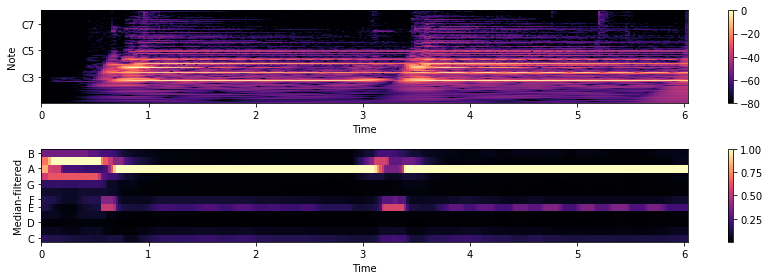

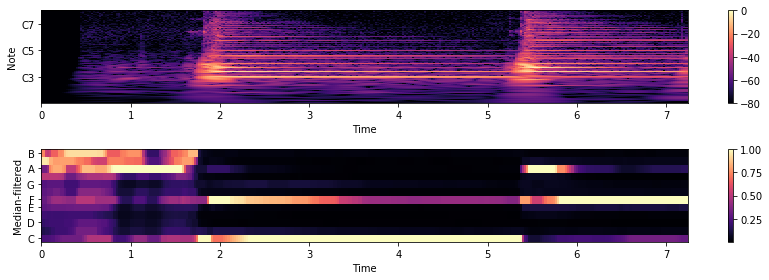

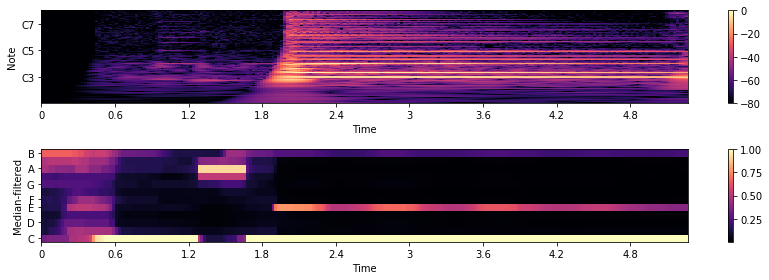

In [154]:
chord_am = get_chromagram(Am, True)
chord_f = get_chromagram(F, True)
chord_c = get_chromagram(C, True)

In [155]:
am_df = chromagram_to_df(chord_am, COLUMNS)
f_df = chromagram_to_df(chord_f, COLUMNS)
c_df = chromagram_to_df(chord_c, COLUMNS)

In [156]:
am_pred = cb_chord_classifier.predict(am_df)
f_pred = cb_chord_classifier.predict(f_df)
c_pred = cb_chord_classifier.predict(c_df)

In [157]:
am_mapped = map_chords(am_pred)
f_mapped = map_chords(f_pred)
c_mapped = map_chords(c_pred)

In [158]:
am_time = get_time_from_song(Am, am_mapped)
f_time = get_time_from_song(F, f_mapped)
c_time = get_time_from_song(C, c_mapped)

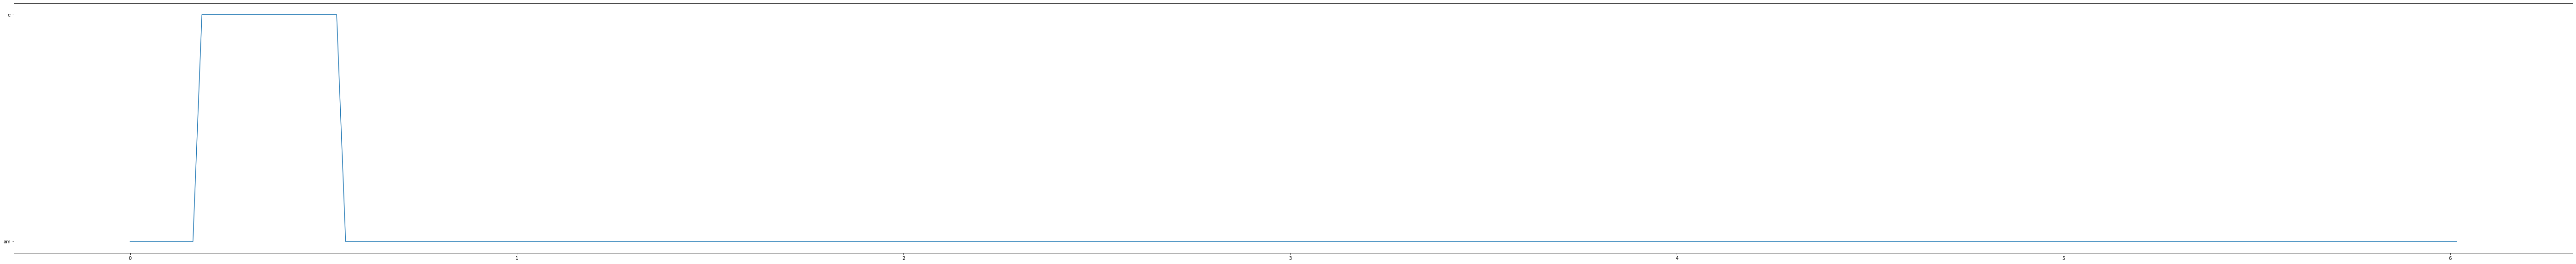

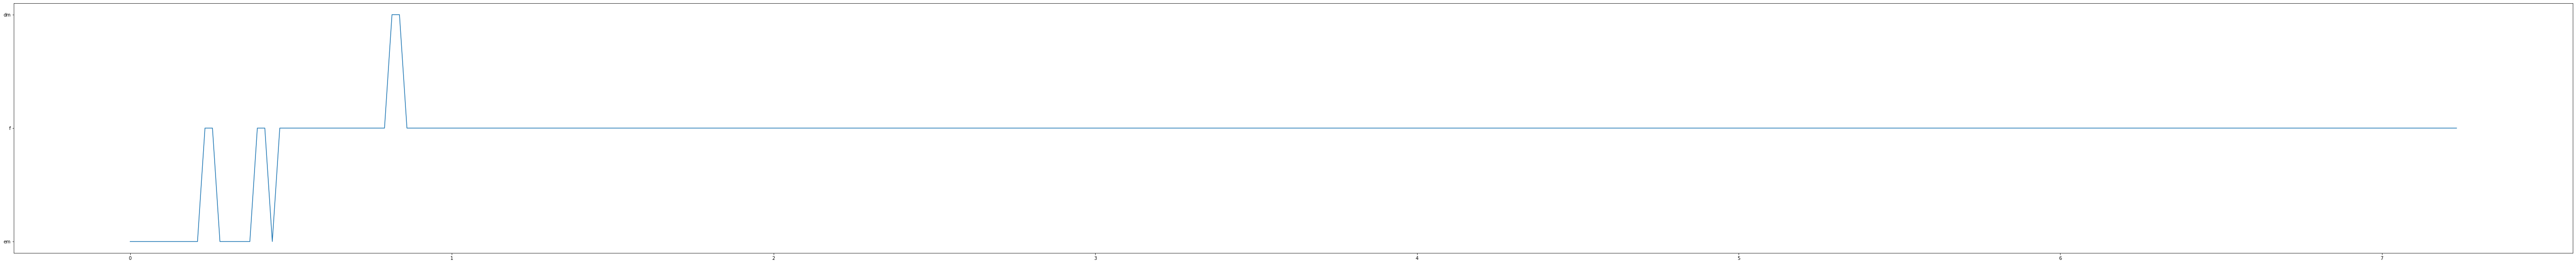

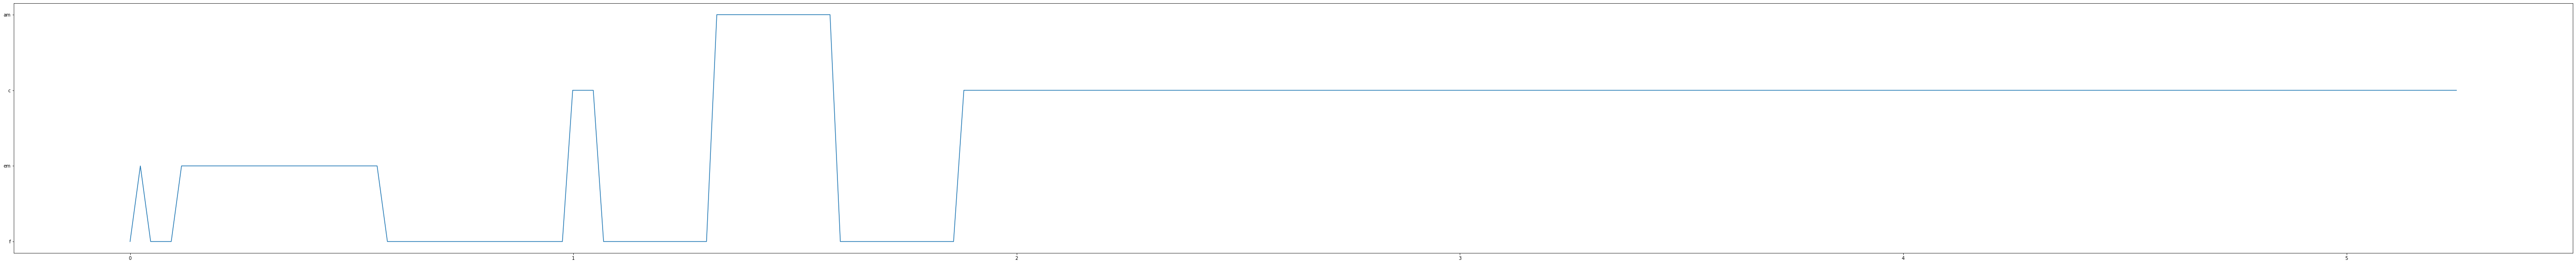

In [159]:
plt.figure(figsize=(100, 10))
plt.plot(am_time, am_mapped)
plt.figure(figsize=(100, 10))
plt.plot(f_time, f_mapped)
plt.figure(figsize=(100, 10))
plt.plot(c_time, c_mapped)

In [160]:
am_mapped = clear_chords(am_mapped, am_time)
f_mapped = clear_chords(f_mapped, f_time)
c_mapped = clear_chords(c_mapped, c_time)

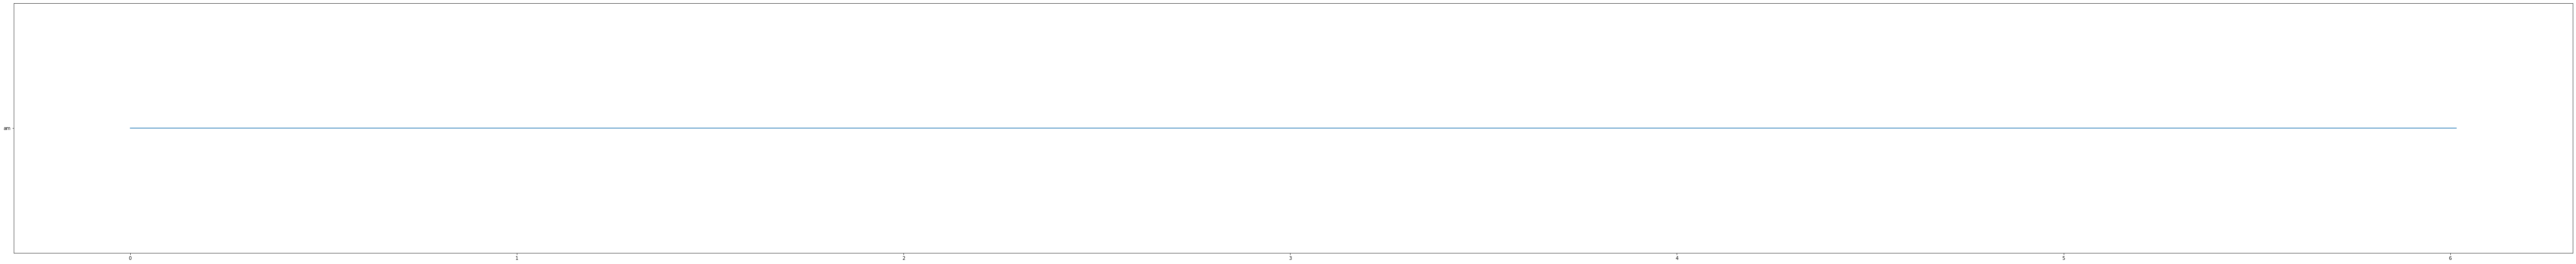

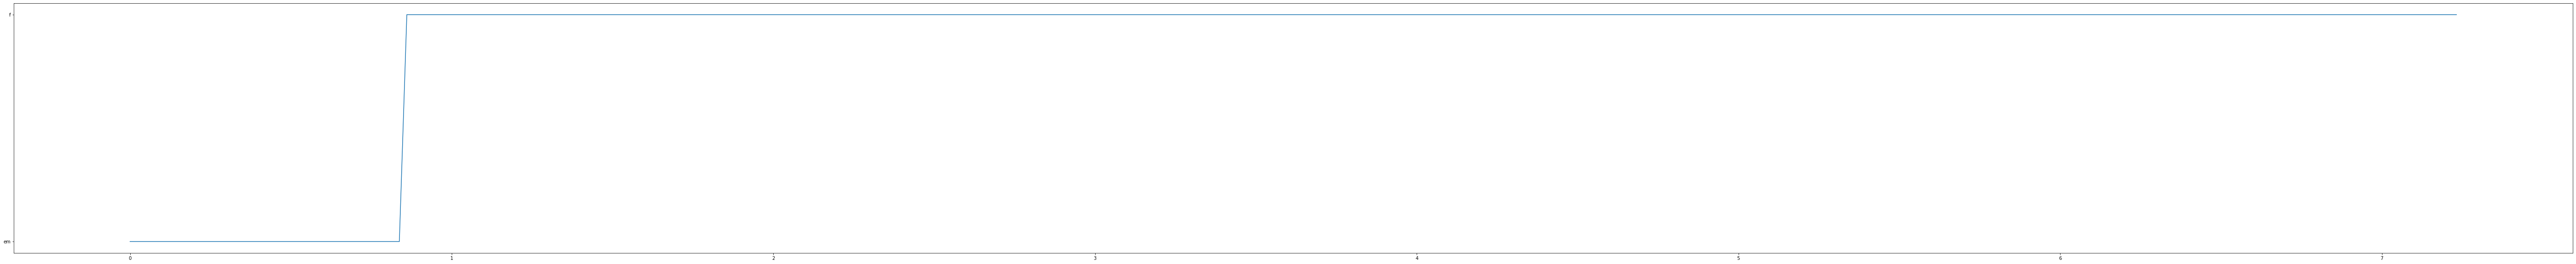

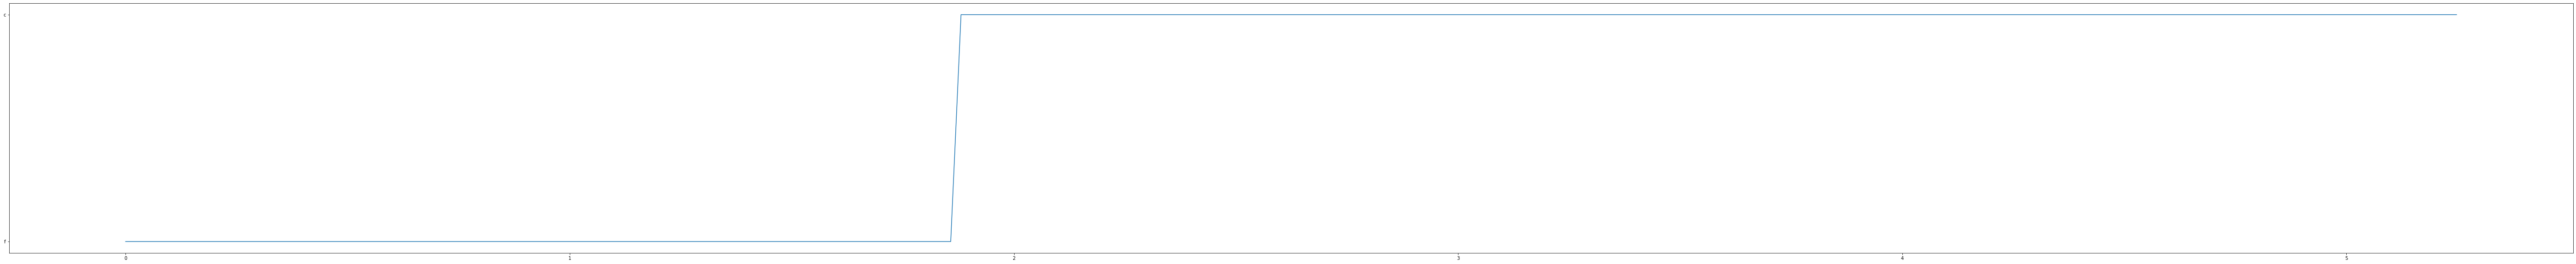

In [161]:
plt.figure(figsize=(100,10))
plt.plot(am_time, am_mapped)
plt.figure(figsize=(100,10))
plt.plot(f_time, f_mapped)
plt.figure(figsize=(100,10))
plt.plot(c_time, c_mapped)

## Operations with song and chords

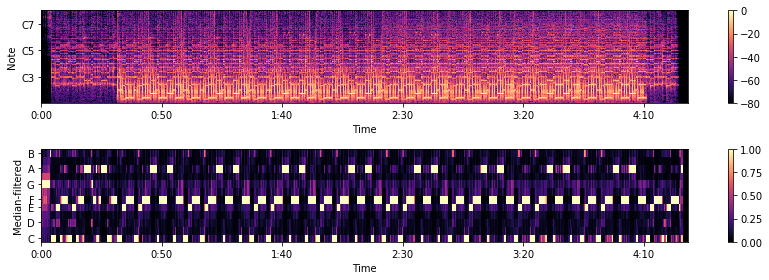

In [150]:
song_chrm = get_chromagram(SONG, True)

In [151]:
# not uses?
song_chg_chords_info = get_chord_changing_info(song_chrm)
song_chg_chords_info = [[song_chrm[i][j] for i in range(12)] 
                        for j in song_chg_chords_info]
song_chg_chords_info

[[0.2928962223499093,
  0.16822252035479998,
  0.2589488596638484,
  0.189649638371203,
  0.19134150452333773,
  0.3075822698865934,
  0.3865089636034484,
  0.721472644193439,
  0.32501512504811686,
  0.34293017462996067,
  0.3441151556047508,
  0.5594032426049622],
 [0.13407790298227387,
  0.13076378019745155,
  0.16966410590425834,
  0.1356147957836004,
  0.16076179631370816,
  0.20077150687578393,
  0.14294741223977972,
  0.45502528169417167,
  0.2227850549448901,
  0.23982825190022872,
  0.2056493484618901,
  0.9165891900806742],
 [0.08483046371016352,
  0.1019398023167482,
  0.10724704935203654,
  0.12756382534498287,
  0.11728637492629305,
  0.166739562994714,
  0.12099440412649852,
  0.3263267805706265,
  0.12354521052508377,
  0.15539910226046882,
  0.17590193452992592,
  0.9231117170795454],
 [1.0,
  0.13410980141511772,
  0.21235276876107473,
  0.06468184069314174,
  0.43116837237677164,
  0.06329191778204485,
  0.05128927899715464,
  0.17719011206489316,
  0.0385851174093632

In [24]:
song_df = chromagram_to_df(song_chrm, COLUMNS)

In [25]:
y_pred = cb_chord_classifier.predict(song_df)

In [152]:
# not use
chords = remove_and_map_chords(y_pred)

In [27]:
len(chords)

164

In [28]:
chords

['f',
 'c',
 'dm',
 'f',
 'dm',
 'f',
 'dm',
 'em',
 'dm',
 'em',
 'bm',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'dm',
 'g',
 'dm',
 'f',
 'am',
 'd',
 'am',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'f',
 'c',
 'f',
 'am',
 'd',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em',
 'f',
 'am',
 'd',
 'f',
 'c',
 'f',
 'am',
 'f',
 'c',
 'f',
 'c',
 'em',
 'f',
 'c',
 'em

In [143]:
def map_chords(chords_indexes):
    """
    Func map chord number to chord symbol.
    
    Parameters:
        chords_indexes - index of chord.
    
    Return:
        result - string with name of chord.
    
    """
    
    mapping = {0: "a", 1: "am", 2: "bm", 3: "c", 4: "d", 5: "dm", 6: "e", 7: "em", 8: "f", 9: "g"}
    result = []
    for chord in chords_indexes:
        result.append(mapping[int(chord)])
    return result

In [133]:
mapped = map_chords(y_pred)

In [57]:
def get_duration(file_path):
    """Func returns duration of song."""
    
    y, sr = librosa.load(file_path)
    return librosa.get_duration(y=y, sr=sr)

In [130]:
def get_time_from_song(file_path, chords):
    """
    Func returns time list of song.
    
    Parameters:
        file_path - path to song.
        chords - list of chords in song.
    
    Return:
        list with equal time periods with length == len(song_chords).
        
    """
    
    duration = get_duration(file_path)
    return [duration*ind/(len(chords)-1) for ind in range(len(chords))]

In [134]:
time = get_time_from_song(SONG, mapped)

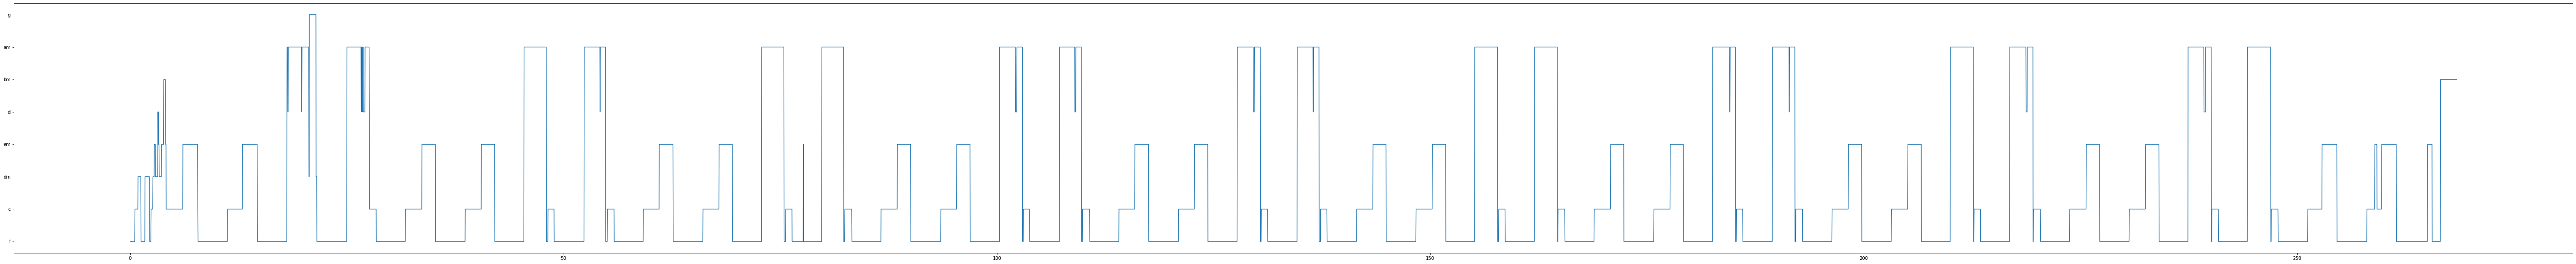

In [138]:
plt.figure(figsize=(100, 10))
plt.plot(time, mapped)

In [139]:
def clear_chords(chords, time, MIN_CHORD_DURATION=1):
    """Func clears chord list from outliers.
    
    Parameters:
        chords - list of song chords.
        time - list with chromagrams periods.
        MIN_CHORD_DURATION - min time of chord duration (in seconds).
        
    Returns:
        chords - list of clear song chords.
    
    """
    
    chords = chords.copy()
    li = 0 # low index
    last_ok = chords[0] # last correct chord
    while li < len(chords) - 1:
        last = chords[li] # last chord
        hi = li + 1 # high index
        while (hi < len(chords) - 1) and (chords[hi] == last):
            # while one chord repeats
            hi += 1

        if time[hi] - time[li] < MIN_CHORD_DURATION: 
            # if chord is too short - change on last ok
            chords[li: hi] = [last_ok for _ in range(hi-li)]        
        else:       
            # if it is a good chord - save it
            last_ok = last
        li = hi
    
    return chords

In [140]:
mapped = clear_chords(mapped, time)

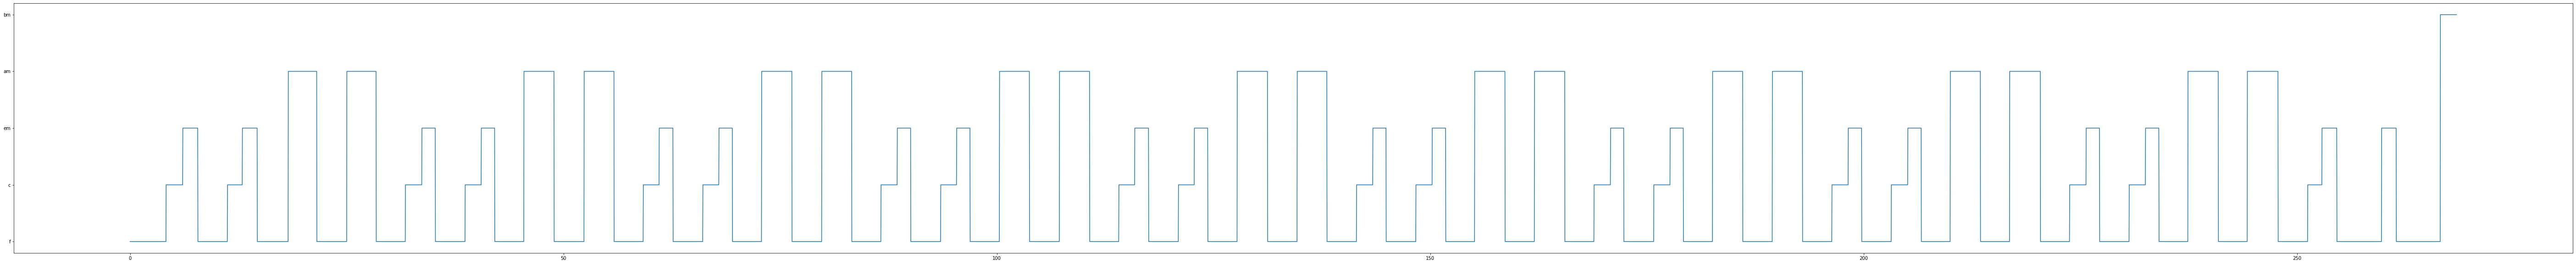

In [141]:
plt.figure(figsize=(100,10))
plt.plot(time, mapped)

## Model Loading

In [127]:
cb_chord_classifier = CatBoostClassifier()
cb_chord_classifier.load_model("cb_chord_classifier")

## Model Saving

In [125]:
cb_chord_classifier.save_model("cb_chord_classifier")

# Модель по расспознованию границы аккордов!!! (эксперимент)

## Добавить в модели рандома: тут и в прошлом при генерации данных

In [76]:
def bounds_to_df(dir_path, chords, num_of_chords, file_format="wav", dest_file="bounds_data.csv"):

    COEFFICIENTS = [0.05, 0.01, 0.45, 0.25]#[0.125, 0.25, 0.5, 0.75, 0.875]
    # dataframe of all data of chords view
    df = pd.DataFrame(columns=[*COLUMNS, "IS_BOUND"])
    # all chords
    for chord in chords:
        print(chord)
        # all version of one chord
        for chord_num in range(num_of_chords):
            # chromagram of all audio of chord
            chord_chromagram = get_chromagram(
                "{0}\\{1}\\{2}{3}.{4}".format(
                    dir_path, chord, chord, chord_num+1, file_format)
            )
            # get some chromagrams from all audio
            for coef in COEFFICIENTS:
                for index in [int(len(chord_chromagram)-1)*coef, (len(chord_chromagram)-1)*(1-coef)]:
                # places of our chromagrams (from the center, the start & the end)                    
                    chord_chromagram_slice = [
                        chord_chromagram[i][int(index)] for i in range(12)
                    ]

                    chord_data = {
                        k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
                    }
                    if coef > 0.15:
                        chord_data["IS_BOUND"] = False
                    else:
                        chord_data["IS_BOUND"] = True
                    df = df.append(chord_data, ignore_index=True)                
    df = df.sample(frac=1)
    df.to_csv(dest_file, index=False)

In [77]:
DATA_DIR = "D:\\iba_project_data\\Guitar_Only"
CHORDS = ["a", "am", "bm", "c", "d", "dm", "e", "em", "f", "g"]
NUM_OF_CHORD_EXAMPLES = 200

bounds_to_df(DATA_DIR, CHORDS, NUM_OF_CHORD_EXAMPLES)

a
am
bm
c
d
dm
e
em
f
g


In [78]:
df = pd.read_csv("bounds_data.csv")

In [94]:
df.loc[(df.IS_BOUND == True), 'IS_BOUND'] = 1
df.loc[(df.IS_BOUND == False), 'IS_BOUND'] = 0

In [95]:
df

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,IS_BOUND
0,0.073180,0.069367,0.261022,0.062657,0.220201,0.225705,0.271540,0.060094,0.243861,0.894269,0.041926,0.030693,0
1,0.047907,0.365623,0.082438,0.068758,0.898564,0.117951,0.139411,0.308273,0.323456,0.802724,0.143028,0.301204,0
2,0.063755,0.365531,0.284297,0.060938,0.166460,0.170021,0.421447,0.445639,0.423836,1.000000,0.123385,0.031755,1
3,0.016213,0.083657,0.813208,0.162923,0.091562,0.029130,0.360331,0.109913,0.008235,1.000000,0.323735,0.006760,0
4,0.084701,0.064251,0.042173,0.109544,0.510607,0.292243,0.224695,0.332772,0.313435,0.855007,0.087836,0.048298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.025681,0.017815,0.173425,0.015159,0.008939,0.035037,0.221608,1.000000,0.060307,0.119837,0.040211,0.401859,1
15996,0.063926,0.018622,0.032098,0.115558,0.546034,0.022342,0.067796,0.137170,1.000000,0.134117,0.042723,0.437108,1
15997,0.052019,0.027932,0.080275,0.018022,0.036821,0.047947,0.707658,0.043001,0.019680,0.047132,0.056030,1.000000,0
15998,0.210211,0.107531,0.030270,0.163097,1.000000,0.137531,0.039192,0.061330,0.174110,0.537711,0.115174,0.064450,1


In [96]:
Xb = df.drop(['IS_BOUND'], axis=1)
yb = df['IS_BOUND']

In [97]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, random_state=42)

In [98]:
bound_classifier = CatBoostClassifier()
bound_classifier.fit(X_train_b, y_train_b)

Learning rate set to 0.033848
0:	learn: 0.6929787	total: 1.45s	remaining: 24m 4s
1:	learn: 0.6926592	total: 1.6s	remaining: 13m 19s
2:	learn: 0.6924803	total: 1.72s	remaining: 9m 32s
3:	learn: 0.6923000	total: 2s	remaining: 8m 18s
4:	learn: 0.6920731	total: 2.2s	remaining: 7m 18s
5:	learn: 0.6918863	total: 2.29s	remaining: 6m 19s
6:	learn: 0.6916259	total: 2.4s	remaining: 5m 39s
7:	learn: 0.6914913	total: 2.54s	remaining: 5m 14s
8:	learn: 0.6913227	total: 2.68s	remaining: 4m 55s
9:	learn: 0.6911265	total: 2.79s	remaining: 4m 36s
10:	learn: 0.6908906	total: 2.9s	remaining: 4m 20s
11:	learn: 0.6907308	total: 3.01s	remaining: 4m 7s
12:	learn: 0.6905624	total: 3.1s	remaining: 3m 55s
13:	learn: 0.6904592	total: 3.2s	remaining: 3m 45s
14:	learn: 0.6903358	total: 3.32s	remaining: 3m 38s
15:	learn: 0.6902075	total: 3.41s	remaining: 3m 29s
16:	learn: 0.6900327	total: 3.49s	remaining: 3m 21s
17:	learn: 0.6898168	total: 3.57s	remaining: 3m 14s
18:	learn: 0.6896081	total: 3.65s	remaining: 3m 8s
19

158:	learn: 0.6760687	total: 17.6s	remaining: 1m 32s
159:	learn: 0.6760431	total: 17.7s	remaining: 1m 33s
160:	learn: 0.6759795	total: 17.8s	remaining: 1m 32s
161:	learn: 0.6759342	total: 18s	remaining: 1m 32s
162:	learn: 0.6758762	total: 18.1s	remaining: 1m 32s
163:	learn: 0.6757836	total: 18.2s	remaining: 1m 33s
164:	learn: 0.6756508	total: 18.4s	remaining: 1m 32s
165:	learn: 0.6756019	total: 18.5s	remaining: 1m 33s
166:	learn: 0.6755668	total: 18.6s	remaining: 1m 32s
167:	learn: 0.6754830	total: 18.7s	remaining: 1m 32s
168:	learn: 0.6753867	total: 18.9s	remaining: 1m 32s
169:	learn: 0.6753333	total: 19s	remaining: 1m 32s
170:	learn: 0.6753126	total: 19.1s	remaining: 1m 32s
171:	learn: 0.6752383	total: 19.2s	remaining: 1m 32s
172:	learn: 0.6752088	total: 19.3s	remaining: 1m 32s
173:	learn: 0.6751199	total: 19.5s	remaining: 1m 32s
174:	learn: 0.6750332	total: 19.6s	remaining: 1m 32s
175:	learn: 0.6749842	total: 19.7s	remaining: 1m 32s
176:	learn: 0.6749673	total: 19.8s	remaining: 1m 3

314:	learn: 0.6675217	total: 32.5s	remaining: 1m 10s
315:	learn: 0.6674972	total: 32.6s	remaining: 1m 10s
316:	learn: 0.6674844	total: 32.7s	remaining: 1m 10s
317:	learn: 0.6674832	total: 32.7s	remaining: 1m 10s
318:	learn: 0.6674036	total: 32.8s	remaining: 1m 10s
319:	learn: 0.6673500	total: 32.9s	remaining: 1m 9s
320:	learn: 0.6672419	total: 32.9s	remaining: 1m 9s
321:	learn: 0.6672284	total: 33s	remaining: 1m 9s
322:	learn: 0.6671985	total: 33.1s	remaining: 1m 9s
323:	learn: 0.6671938	total: 33.1s	remaining: 1m 9s
324:	learn: 0.6671720	total: 33.4s	remaining: 1m 9s
325:	learn: 0.6671099	total: 33.4s	remaining: 1m 9s
326:	learn: 0.6670668	total: 33.5s	remaining: 1m 8s
327:	learn: 0.6670193	total: 33.6s	remaining: 1m 8s
328:	learn: 0.6669533	total: 33.6s	remaining: 1m 8s
329:	learn: 0.6669418	total: 33.7s	remaining: 1m 8s
330:	learn: 0.6669015	total: 33.8s	remaining: 1m 8s
331:	learn: 0.6668999	total: 33.8s	remaining: 1m 8s
332:	learn: 0.6668974	total: 33.8s	remaining: 1m 7s
333:	lear

474:	learn: 0.6617677	total: 44.6s	remaining: 49.2s
475:	learn: 0.6617462	total: 44.6s	remaining: 49.1s
476:	learn: 0.6617148	total: 44.7s	remaining: 49s
477:	learn: 0.6616921	total: 44.8s	remaining: 48.9s
478:	learn: 0.6616351	total: 44.9s	remaining: 48.8s
479:	learn: 0.6616349	total: 44.9s	remaining: 48.7s
480:	learn: 0.6615891	total: 45s	remaining: 48.6s
481:	learn: 0.6615338	total: 45.1s	remaining: 48.5s
482:	learn: 0.6615268	total: 45.2s	remaining: 48.4s
483:	learn: 0.6614815	total: 45.3s	remaining: 48.3s
484:	learn: 0.6613958	total: 45.3s	remaining: 48.1s
485:	learn: 0.6613416	total: 45.4s	remaining: 48s
486:	learn: 0.6612961	total: 45.5s	remaining: 48s
487:	learn: 0.6612518	total: 45.6s	remaining: 47.9s
488:	learn: 0.6612034	total: 45.7s	remaining: 47.7s
489:	learn: 0.6612028	total: 45.7s	remaining: 47.6s
490:	learn: 0.6611885	total: 45.8s	remaining: 47.5s
491:	learn: 0.6611426	total: 45.9s	remaining: 47.4s
492:	learn: 0.6610507	total: 45.9s	remaining: 47.2s
493:	learn: 0.660973

633:	learn: 0.6568292	total: 56.9s	remaining: 32.9s
634:	learn: 0.6568033	total: 57s	remaining: 32.8s
635:	learn: 0.6567369	total: 57.1s	remaining: 32.7s
636:	learn: 0.6567320	total: 57.1s	remaining: 32.6s
637:	learn: 0.6567320	total: 57.2s	remaining: 32.4s
638:	learn: 0.6567315	total: 57.2s	remaining: 32.3s
639:	learn: 0.6567306	total: 57.2s	remaining: 32.2s
640:	learn: 0.6567306	total: 57.3s	remaining: 32.1s
641:	learn: 0.6567061	total: 57.3s	remaining: 32s
642:	learn: 0.6566502	total: 57.4s	remaining: 31.9s
643:	learn: 0.6566499	total: 57.5s	remaining: 31.8s
644:	learn: 0.6565688	total: 57.5s	remaining: 31.7s
645:	learn: 0.6565626	total: 57.6s	remaining: 31.6s
646:	learn: 0.6565155	total: 57.6s	remaining: 31.5s
647:	learn: 0.6564495	total: 57.7s	remaining: 31.4s
648:	learn: 0.6564366	total: 57.8s	remaining: 31.2s
649:	learn: 0.6563714	total: 57.8s	remaining: 31.1s
650:	learn: 0.6563296	total: 57.9s	remaining: 31.1s
651:	learn: 0.6563296	total: 58s	remaining: 30.9s
652:	learn: 0.6562

796:	learn: 0.6520049	total: 1m 7s	remaining: 17.3s
797:	learn: 0.6520048	total: 1m 7s	remaining: 17.2s
798:	learn: 0.6519903	total: 1m 7s	remaining: 17.1s
799:	learn: 0.6519882	total: 1m 7s	remaining: 17s
800:	learn: 0.6519795	total: 1m 8s	remaining: 16.9s
801:	learn: 0.6519430	total: 1m 8s	remaining: 16.8s
802:	learn: 0.6519161	total: 1m 8s	remaining: 16.7s
803:	learn: 0.6519136	total: 1m 8s	remaining: 16.6s
804:	learn: 0.6518682	total: 1m 8s	remaining: 16.5s
805:	learn: 0.6518522	total: 1m 8s	remaining: 16.5s
806:	learn: 0.6517746	total: 1m 8s	remaining: 16.4s
807:	learn: 0.6517410	total: 1m 8s	remaining: 16.3s
808:	learn: 0.6516761	total: 1m 8s	remaining: 16.2s
809:	learn: 0.6516760	total: 1m 8s	remaining: 16.1s
810:	learn: 0.6516748	total: 1m 8s	remaining: 16s
811:	learn: 0.6516644	total: 1m 8s	remaining: 15.9s
812:	learn: 0.6516257	total: 1m 8s	remaining: 15.8s
813:	learn: 0.6515141	total: 1m 8s	remaining: 15.7s
814:	learn: 0.6515036	total: 1m 8s	remaining: 15.7s
815:	learn: 0.65

953:	learn: 0.6480531	total: 1m 18s	remaining: 3.77s
954:	learn: 0.6480344	total: 1m 18s	remaining: 3.69s
955:	learn: 0.6479800	total: 1m 18s	remaining: 3.61s
956:	learn: 0.6479365	total: 1m 18s	remaining: 3.52s
957:	learn: 0.6479235	total: 1m 18s	remaining: 3.44s
958:	learn: 0.6478664	total: 1m 18s	remaining: 3.36s
959:	learn: 0.6478412	total: 1m 18s	remaining: 3.28s
960:	learn: 0.6477793	total: 1m 18s	remaining: 3.2s
961:	learn: 0.6477641	total: 1m 18s	remaining: 3.12s
962:	learn: 0.6477639	total: 1m 18s	remaining: 3.03s
963:	learn: 0.6476971	total: 1m 18s	remaining: 2.95s
964:	learn: 0.6476642	total: 1m 19s	remaining: 2.87s
965:	learn: 0.6476546	total: 1m 19s	remaining: 2.78s
966:	learn: 0.6475706	total: 1m 19s	remaining: 2.7s
967:	learn: 0.6475255	total: 1m 19s	remaining: 2.62s
968:	learn: 0.6475255	total: 1m 19s	remaining: 2.54s
969:	learn: 0.6475250	total: 1m 19s	remaining: 2.45s
970:	learn: 0.6475175	total: 1m 19s	remaining: 2.37s
971:	learn: 0.6475153	total: 1m 19s	remaining: 2

In [102]:
y_pred_b = bound_classifier.predict(X_test_b)
precision_score(y_test_b, y_pred_b)

0.47892271662763464

In [103]:
recall_score(y_test_b, y_pred_b)

0.4127144298688194